This code ingests:

- A folder of `.json` files generated by OpenFace.
- A folder of images in `Teenie_Harris_PNG1600`

And outputs:

- `images.npy` the cropped imags
- `indices.npy` the index of face within the photo
- `descriptors.npy` the OpenFace descriptor for the face
- `filenames.csv` the filename the face was taken from

Each file has the same number of rows.

In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
from utils.imutil import *
from utils.list_all_files import *
from utils.crop import *
from utils.progress import *
from utils.mosaic import *
from utils.draw_shapes import *

In [2]:
input_dir = '../data/openface/json/'
output_dir = '../data/openface/npy32/'
output_side = 32
output_dtype = np.uint8 # the png1600 images are uint16 for some reason

In [3]:
def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in _nsre.split(s)]

def get_id(fn):
    return os.path.splitext(os.path.basename(fn))[0]

tasks = []
for input_fn in list_all_files(input_dir):
    tasks.append(input_fn)

tasks.sort(key=lambda x: natural_sort_key(get_id(x)))

def job(task):
    try:
        metadata = json.load(open(task))
        out = []
        img = imread(fn)
        for i, face in enumerate(metadata['faces']):
                w,n,e,s = face['box']
                # force it square
                rows = s - n
                cols = e - w
                side = min(rows, cols)
                s = n + side
                e = w + side
                face_img = safe_crop(img, n, s, w, e, fill=0)
                face_img = imresize(face_img, max_side=output_side)
                if output_dtype is not None:
                    face_img = face_img.astype(output_dtype)
                face_rep = np.asarray(face['rep'])
                out.append((task, i, face_img, face_rep))
        return out
    except:
        print(task, metadata['path'], face['box'])
        raise

results = progress_parallel(job, tasks)
results = [item for sublist in results for item in sublist] # flatten results

59278 0:03:25 288.77/s


In [4]:
input_filenames, face_indices, face_images, face_descriptors = list(zip(*results))
face_images = np.asarray(face_images)
face_descriptors = np.asarray(face_descriptors)

In [5]:
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, 'images.npy'), face_images)
np.save(os.path.join(output_dir, 'indices.npy'), face_indices)
np.save(os.path.join(output_dir, 'descriptors.npy'), face_descriptors)
np.savetxt(os.path.join(output_dir, 'filenames.csv'), input_filenames, fmt='%s')

In [15]:
# imshow(make_mosaic(face_images[:495*495]), fmt='jpg')

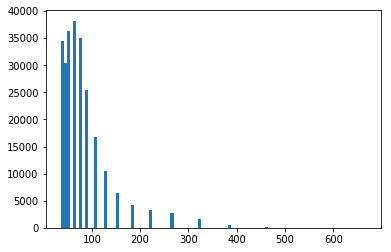

0.88043982329


In [50]:
plt.hist(results, bins=100)
plt.show()
results.sort()

# plt.plot(results)
# plt.yscale('log')
# plt.show()

# 88% of faces are smaller than 128 pixels
print(np.sum(np.asarray(results) < output_side) / len(results))